In [272]:
import pandas as pd 
import configparser
import boto3
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
import numpy as np 
import string
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from math import sqrt
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np 

In [241]:
Config = configparser.ConfigParser()
Config.read_file(open('/Users/milesklingenberg/Documents/Personal/AWS/AWS_Keys'))

In [242]:
KEY = Config.get('AWS', 'AWS_ACCESS_KEY_ID')
SECRET = Config.get('AWS', 'Secret')

In [243]:
s3client = boto3.client('s3', 
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET)

file = s3client.get_object(Bucket = 'disaster-tweet', Key = 'train.csv')
test_file = s3client.get_object(Bucket = 'disaster-tweet', Key = 'test.csv')

In [244]:
tweets_train = pd.read_csv(file['Body'])
tweets_train = pd.DataFrame(tweets_train)

In [245]:
tweets_test = pd.read_csv(test_file['Body'])
tweets_test = pd.DataFrame(tweets_test)

In [246]:
tweets_train['istrain']= True
tweets_test['istrain'] = False

full = pd.concat([tweets_train, tweets_test])

full.head(2)

,id,keyword,location,text,target,istrain
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,True


In [247]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
 5   istrain   10876 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 520.4+ KB


In [248]:
full.isna().sum()

id             0
keyword       87
location    3638
text           0
target      3263
istrain        0
dtype: int64

In [249]:
#target null is the lenght of our test data, so that looks fine. 
#Quite of bit for the locaiton though, seems a little odd. 
full[full['istrain']==True].isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
istrain        0
dtype: int64

In [250]:
#Most are coming from the training set. 

In [251]:
##Let's start enriching the data. 

In [252]:
nlp = spacy.load('en_core_web_sm')

In [253]:
def add_spacy_data(dataset, feature_column):
    '''
    Grabbing verbs, adverbs, nouns and a clean text. 
    
    Parameters:
    
    dataset (dataframe): the dataframe to parse
    feature_column (string): the column to parse in the dataset.
    
    '''
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    hashtags = []
    for i in range (0, len(dataset)):
        tweet = dataset.iloc[i][feature_column]
        doc = nlp(tweet)
        spacy_dataframe = pd.DataFrame()
        for token in doc:
            if token.lemma_ == "-PRON-":
                    lemma = token.text
            else:
                lemma = token.lemma_
                
            row = {
                "Word": token.text,
                "Lemma": lemma,
                "PoS": token.pos_,
                "Stop Word": token.is_stop, 
            }
            spacy_dataframe = spacy_dataframe.append(row, ignore_index = True)
        verbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "VERB"].values))
        nouns.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADV"].values))
        corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
        corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   
        corpus.append(corpus_clean)
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    return dataset

spacy_data = add_spacy_data(full, 'text')

In [254]:
spacy_data.head(2)

,id,keyword,location,text,target,istrain,Verbs,Nouns,Adverbs,Corpus
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,True,forgive,earthquake,,Deeds Reason earthquake ALLAH forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,True,,forest fire,,forest fire near La Ronge Sask Canada


In [255]:
#The next thing we will want to do is look at some of the other characters
#within a tweet. I have a sneaking suspiscion that someone will not include 
#a hastag if it truly is a disaster. I am also curious to see if they will include a link if 
#it is a disaster. 

In [256]:
spacy_data['#Nouns'] = spacy_data['Nouns'].str.split().str.len()
spacy_data['#Verbs'] = spacy_data['Verbs'].str.split().str.len()
spacy_data['#Adverbs'] = spacy_data['Adverbs'].str.split().str.len()

In [257]:
spacy_data[spacy_data.duplicated()]

,id,keyword,location,text,target,istrain,Verbs,Nouns,Adverbs,Corpus,#Nouns,#Verbs,#Adverbs


In [258]:
#Nothing is duplicated. That is good. 

In [259]:
#Let's look at the keywords. 

<ipython-input-260-b4a24e44b602>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')


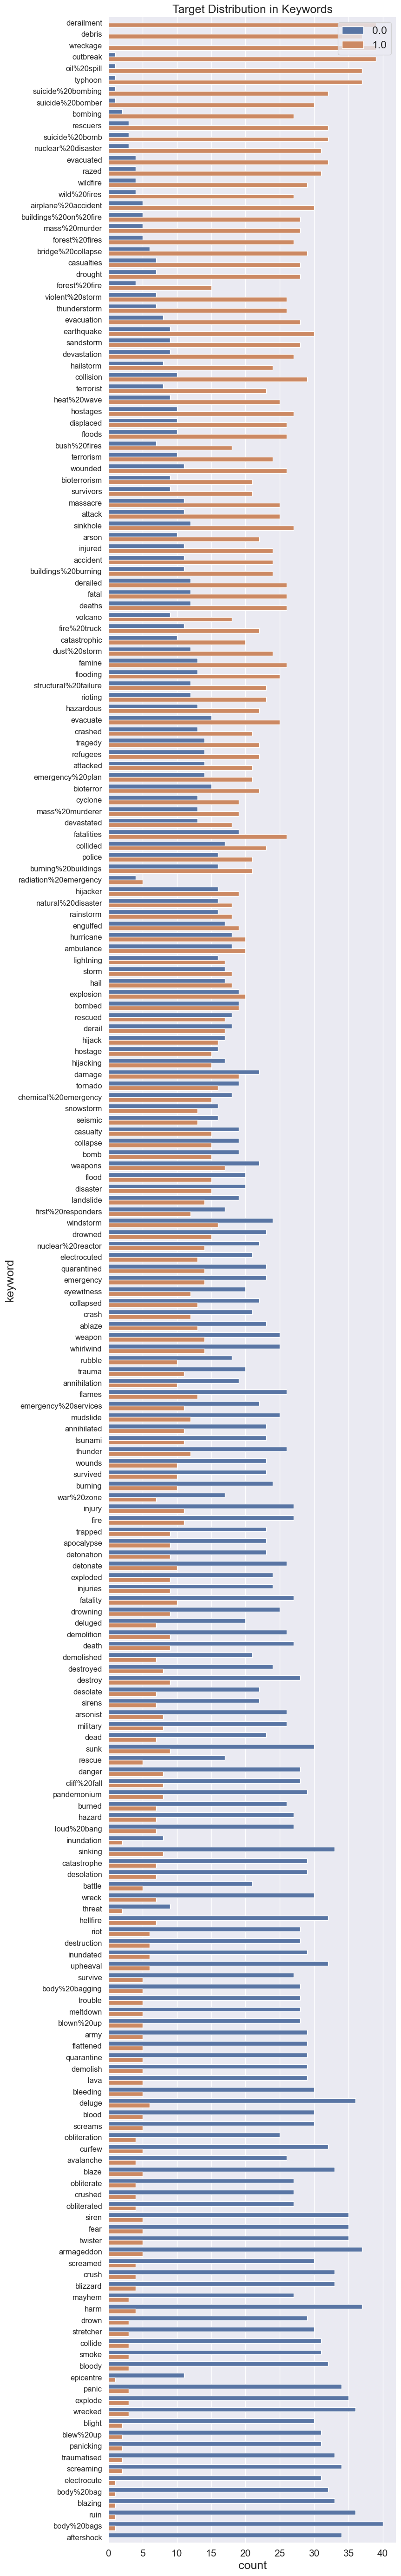

/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [260]:
df_train = full[full['istrain']==True]
df_test = full[full['istrain']==False]

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')


fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [261]:
##let's add a few more things to our datasets
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

<ipython-input-261-76b604ef7a2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
<ipython-input-261-76b604ef7a2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
<ipython-input-261-76b604ef7a2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


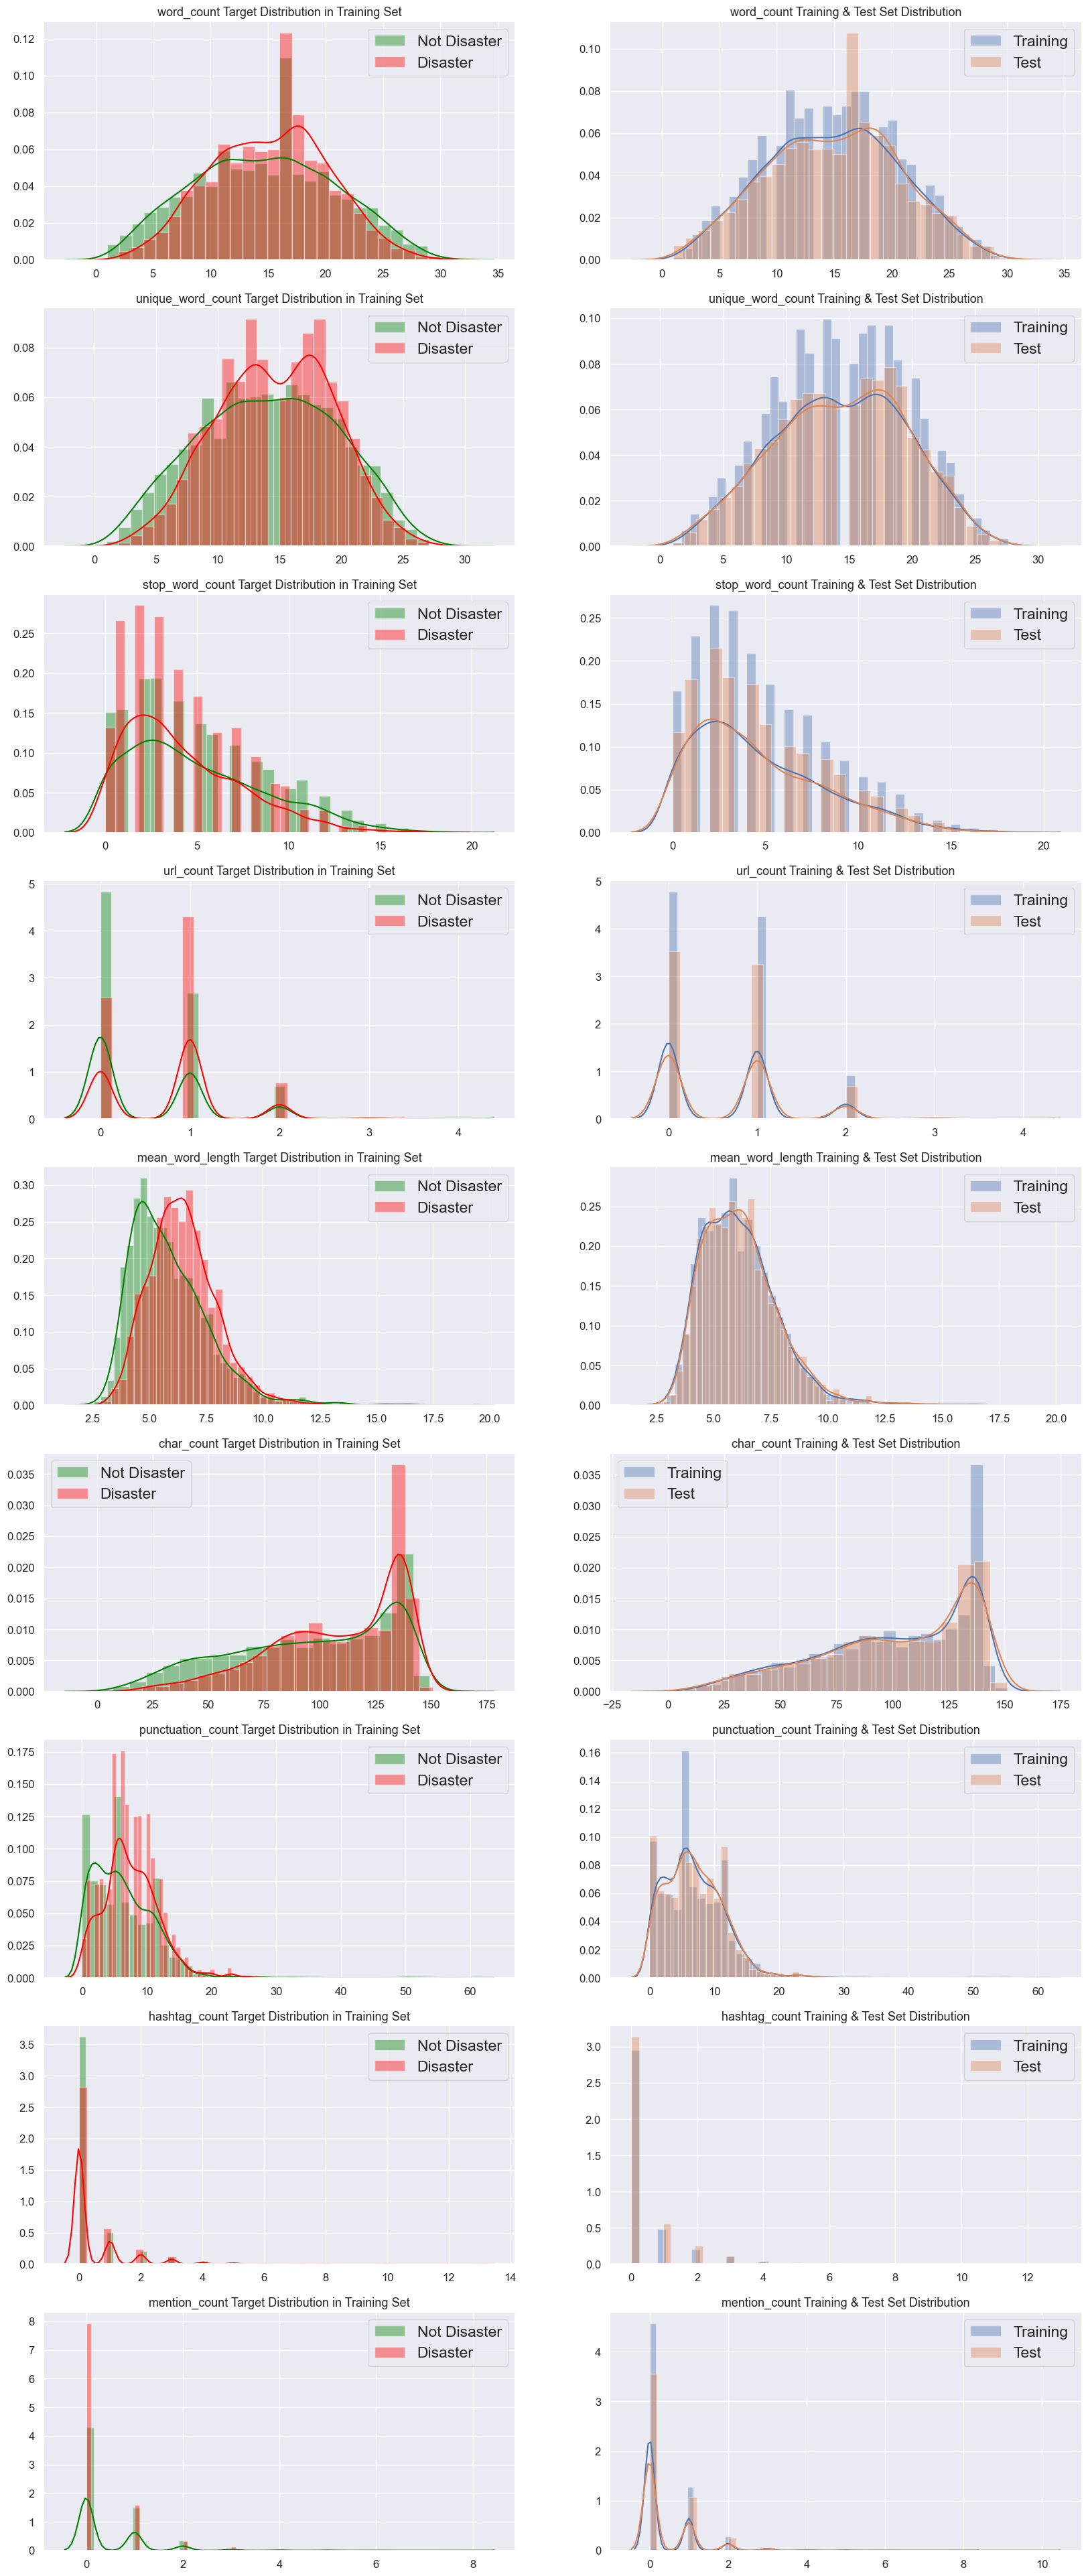

In [262]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()


In [263]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']

In [264]:
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [265]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

<ipython-input-265-d814b1bc0539>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target_relabeled'] = df_train['target'].copy()
/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [279]:
from transformers import BertTokenizer
#Going to try the Bert Tokenizer 

In [285]:
input_ids = [] 

lengths = [] 

for sentences in df_train.text: 
         encoded_sent = tokenizer.encode(
                                sentences, 
                                add_special_tokens=True, 
         )
         input_ids.append(encoded_sent)
        
         lengths.append(len(encoded_sent))
            

In [286]:
labels = df_train.target.to_numpy().astype(int)

In [287]:
print (' Min length: {:,} tokens'.format(min(lengths)))
print('Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

 Min length: 3 tokens
Max length: 84 tokens
Median length: 33.0 tokens


<module 'matplotlib.pyplot' from '/usr/local/Cellar/jupyterlab/2.1.1/libexec/lib/python3.8/site-packages/matplotlib/pyplot.py'>

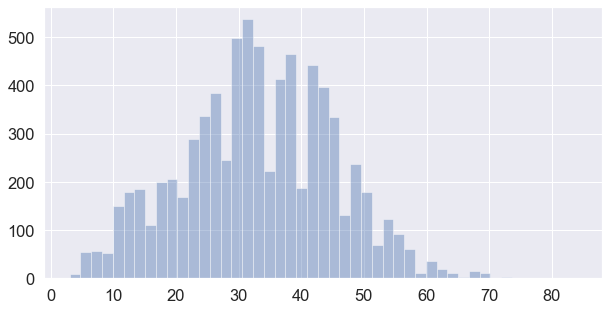

In [288]:
#The good news is that the bert tokenizer cannot tokenize for anything past 
#512 tokens for the special tokens at the end and the beginning. 

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"]=(10,5)

sns.distplot(lengths, kde=False, rug=False)
plt

In [1]:
from keras.preprocessing.sequence import pad_sequences 

MAX_LEN = 128 

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                         value=0, truncating="post", padding="post")

Using TensorFlow backend.


NameError: name 'input_ids' is not defined